# Обучение модели машинного обучения

**Описание данных:**
- в нашем распоряжении 4 таблицы с данными
 - Файл market_file.csv, содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 - Файл market_money.csv, с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
 - Файл market_time.csv с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 - Файл money.csv с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Цель исследования**
 - разработать модель машинного обучения, которая предскажет вероятность снижения покупательской активности клиента, выделить сегменты покупателей и разработать для них персонализированные предложения

**Ход исследования:**
- загрузим и проанализируем предоставленные данные
- предобработка данных
- исследование полученных данных с их визуализацией
- проведение корреляционного анализа
- обьединение таблиц
- с использованием пайплайнов обучить четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). выберать лучшую модель, используя метрику. 
- анализ важности признаков помощью метода SHAP 
- проведение графического и аналитического исследование группы покупателей.
- разработать предложения по работе с сегментом для увеличения покупательской активности.
- сделаем итоговые выводы

In [1]:
#pip install scikit-learn==1.1 -q

In [2]:
#pip install phik -q

In [3]:
#pip install shap -q

In [4]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import phik

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.compose import ColumnTransformer

# загружаем нужные метрики
from sklearn.metrics import roc_auc_score

#Интерпретируемость моделей
#import shap

# настройка размера графиков
plt.rcParams["figure.figsize"] = (13, 9)

## Шаг 1. Загрузка данных

In [5]:
#market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
market_file = pd.read_csv('market_file.csv', sep=',')
market_money = pd.read_csv('market_money.csv', sep=',')
market_time = pd.read_csv('market_time.csv', sep=',')
money = pd.read_csv('money.csv', sep=';')

In [6]:
display(market_file.head())
display(market_money.head())
display(market_time.head())
display(money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [7]:
market_file.info()
print('\n')
market_money.info()
print('\n')
market_time.info()
print('\n')
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Имеем 4 таблицы. данные в таблицах соответствуют описанию

В таблице market_file 1300 записи и 13 столбцов.
В таблице market_money 3900 записей и 3 столбца. 
В таблице market_time 2600 записей и 3 столбца.
В таблице money 1300 записей и 2 столбца.


## Шаг 2. Предобработка данных

Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

In [8]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Пропуски в данных отсутствуют.

In [9]:
#заменим нижние подчекивания на пробел
market_file.columns = market_file.columns.str.replace('_', ' ')

#market_file.columns = market_file.columns.str.lower().str.replace('_', ' ')

In [10]:
market_file.duplicated().sum()

np.int64(0)

Пропуски и дубликаты отсутствуют.

Рассмотрим категориальные переменные:

In [11]:
col = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная категория']
for i in col:
    display(market_file[i].value_counts())

Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64

Популярная категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

In [12]:
#заменим данные в столбце 'Тип сервиса' на корректные
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт','стандарт')
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [13]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [14]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [15]:
market_money.duplicated().sum()

np.int64(0)

Пропуски и дубликаты отсутствуют.

Рассмотрим категориальные переменные:

In [16]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [17]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [18]:
market_time.duplicated().sum()

np.int64(0)

Пропуски и дубликаты отсутствуют.

Рассмотрим категориальные переменные:

In [19]:
display(market_time['Период'].value_counts())

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [20]:
# заменим значение в столбце 'Период' на корректное:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


In [21]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [22]:
#изменим тип данных на корректный
money['Прибыль'] = money['Прибыль'].str.replace(',', '.')
money['Прибыль'] = money['Прибыль'].astype('float64')

In [23]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [24]:
money.duplicated().sum()

np.int64(0)

#### Промежуточный вывод по этапу предобработки:

Во всех датафреймах не было пропусков и дубликатов.
- В датафрейме market_file были приведены к корректному виду названия столбцов, заменены данные в столбце 'Тип сервиса' на корректные.
- В датафрейме market_money были заменены типы данных.
- В датафрейме market_time были заменены значения в столбце 'Период' на корректное.
- В датафрейме money были заменены типы данных.


## Шаг 3. Исследовательский анализ данных
Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 

In [25]:
market_money.query('Выручка < 1')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [26]:
values = market_money[market_money['Выручка'] == 0]['id'].unique()
display(values)

array([215348, 215357, 215359])

In [27]:
market_money = market_money[market_money['id'].isin(values) == False ]
market_file = market_file[market_file['id'].isin(values) == False ]
market_time = market_time[market_time['id'].isin(values) == False ]
money = money[money['id'].isin(values) == False ]

In [28]:
market_money.info()
market_file.info()
market_time.info()
money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   Период   3891 non-null   object 
 2   Выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет актив 6 мес                   1297 non-null   float64
 5   Маркет актив тек мес                 1297 non-null   int64  
 6   Длительнос

Итог: убрали из данных информацию и пользователях с нулевой выручкой.

In [29]:
market_file.describe()

,id,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


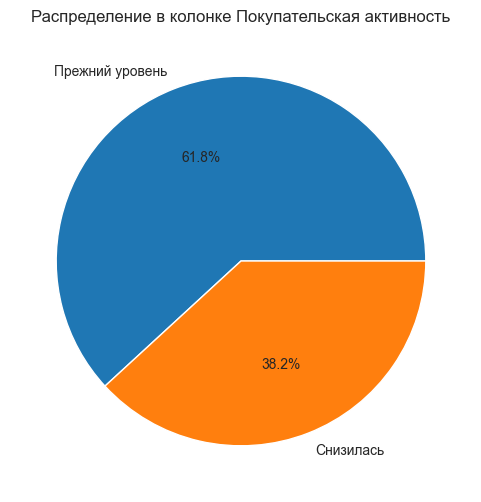

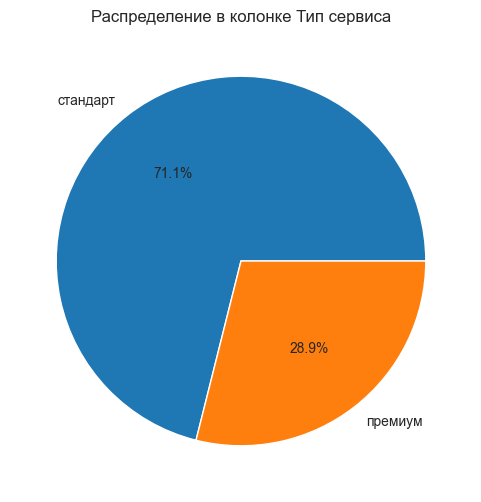

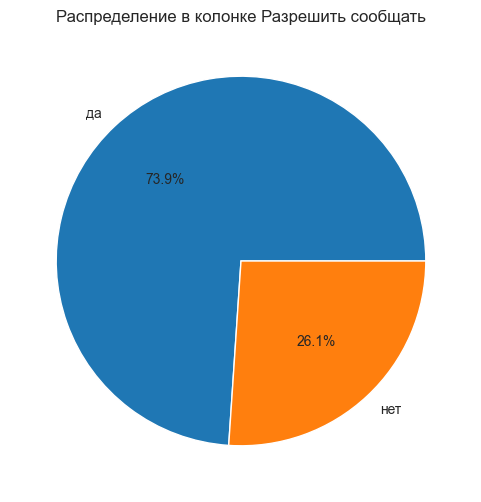

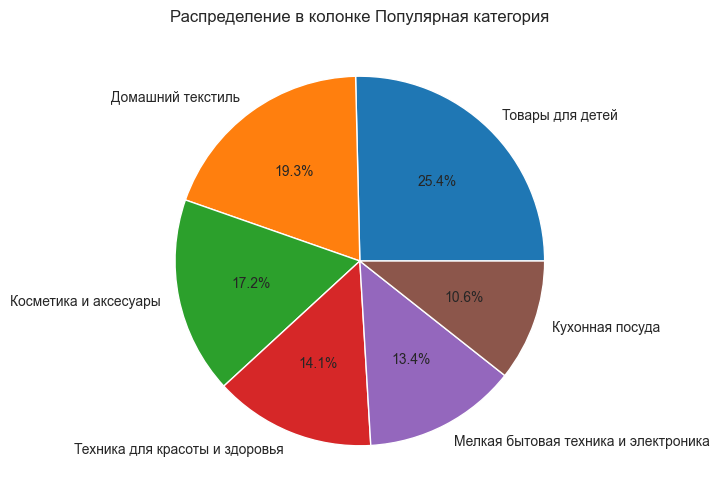

In [30]:
cat_col = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная категория']

for i in cat_col:
    counts = market_file[i].value_counts()  
    plt.figure(figsize=(6, 6))
    plt.pie(counts, autopct='%1.1f%%', labels=counts.index)
    plt.title(f'Распределение в колонке {i}')
    plt.show()


Присутствует дисбаланс в целевой переменной. Использование stratify позволит сохранить баланс меток классов 1/0.

- покупательская_активность снизилась у 38,2% клиентов. больше 1/3 покупателей - достаточно высокий показатель. 
- премиум сервисом пользуются 28,9% от всей выборки клиентов.
- 74% клиентов дают согласие на рассылки по товару.
- Распределение популярых категорий выглядит следующим образом:
 - товары для детей: 25,4%
 - домашний текстиль 19,3%
 - косметика и аксесуары 17,2%
 - техника для красоты и здоровья 14,1%
 - мелкая бытовая техника и электроника 13,4%
 - кухонная посуда 10,6%

In [31]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность',
       'Акционные покупки', 'Популярная категория',
       'Средний просмотр категорий за визит',
       'Неоплаченные продукты штук квартал', 'Ошибка сервиса',
       'Страниц за визит'],
      dtype='object')

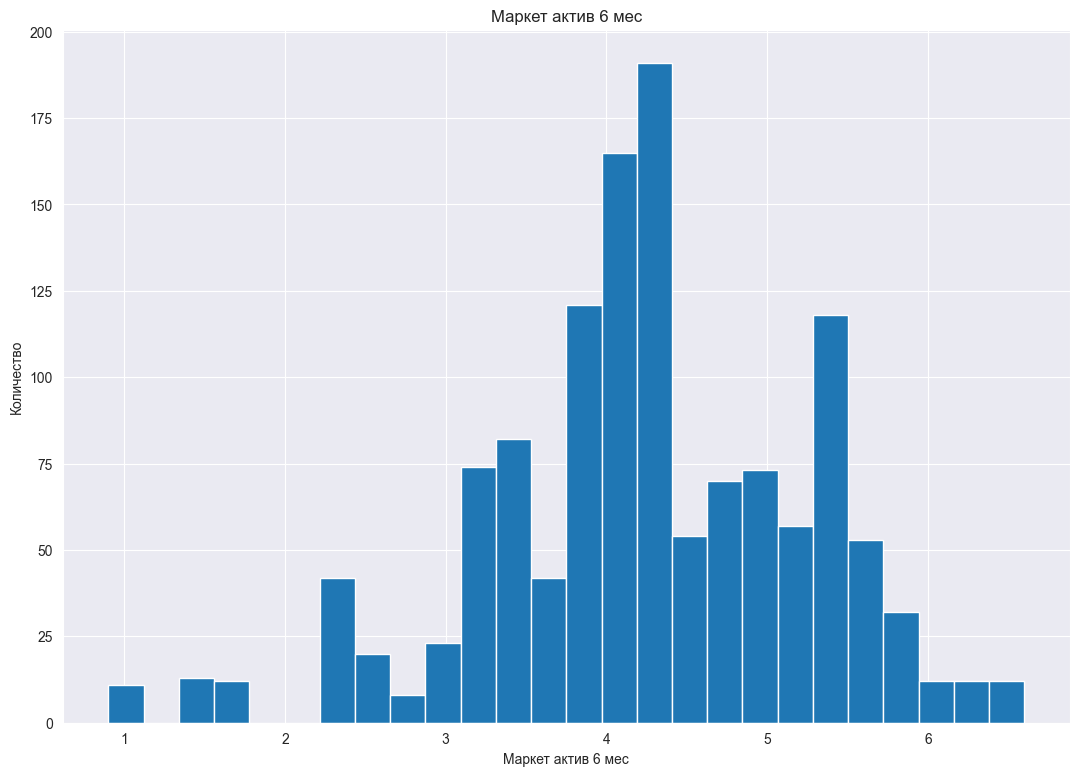

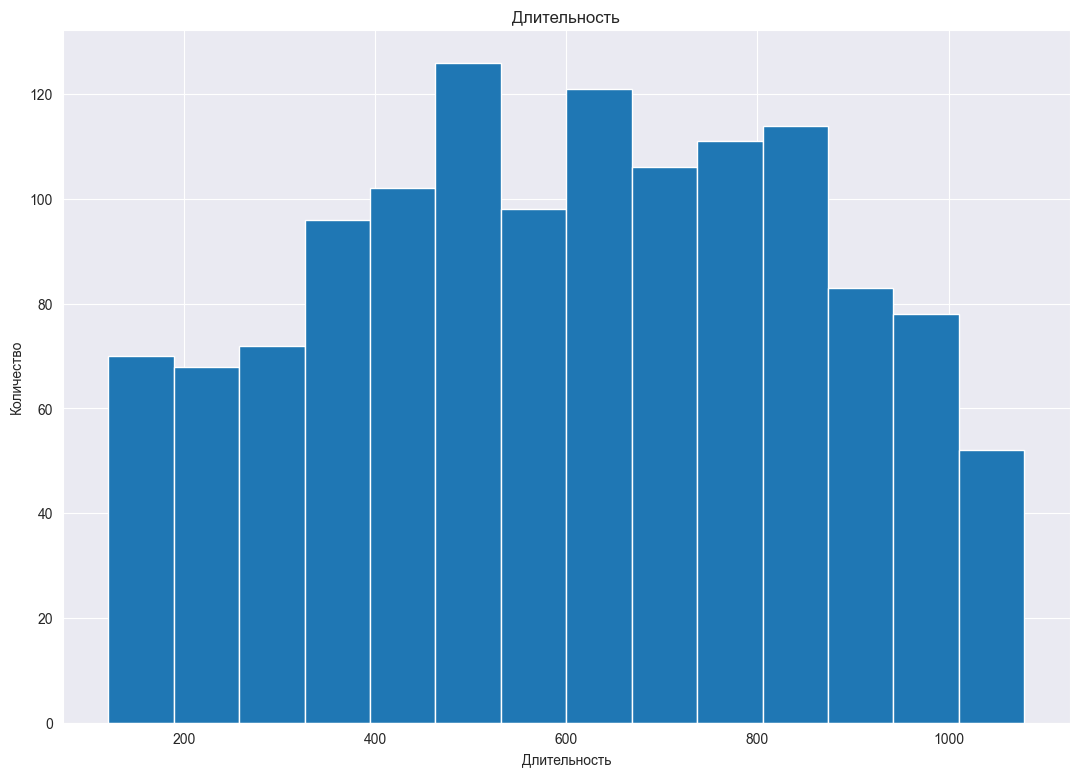

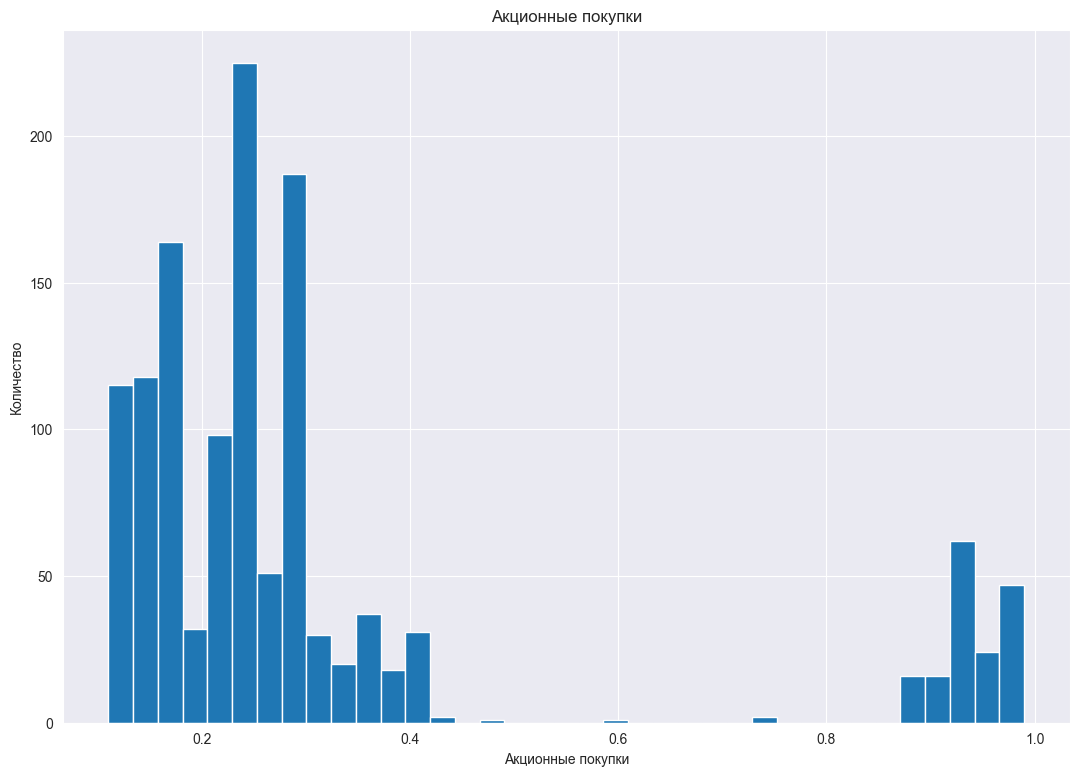

In [32]:
col = ['Маркет актив 6 мес', 'Длительность', 'Акционные покупки']

#plt.rcParams["figure.figsize"] = (13, 9) 

for i in col:
    plt.hist(x=market_file[i], bins='auto')
    plt.grid(True)
    plt.ylabel("Количество")
    plt.xlabel(i)
    plt.title(i)
    plt.show()

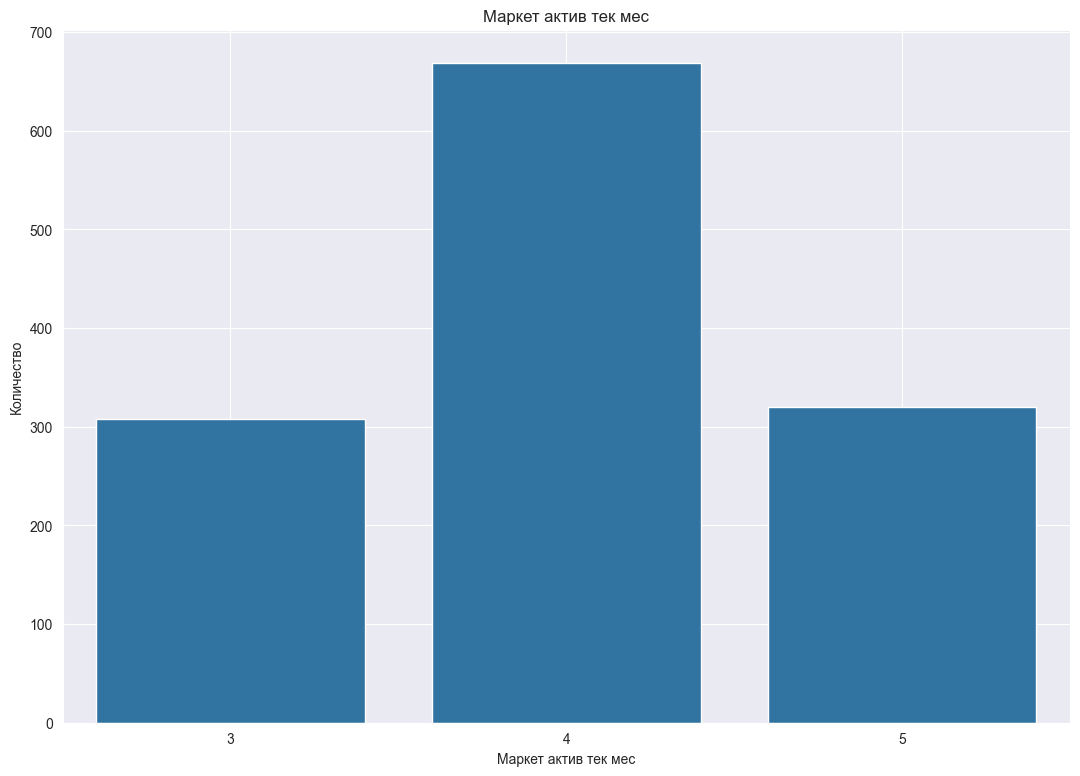

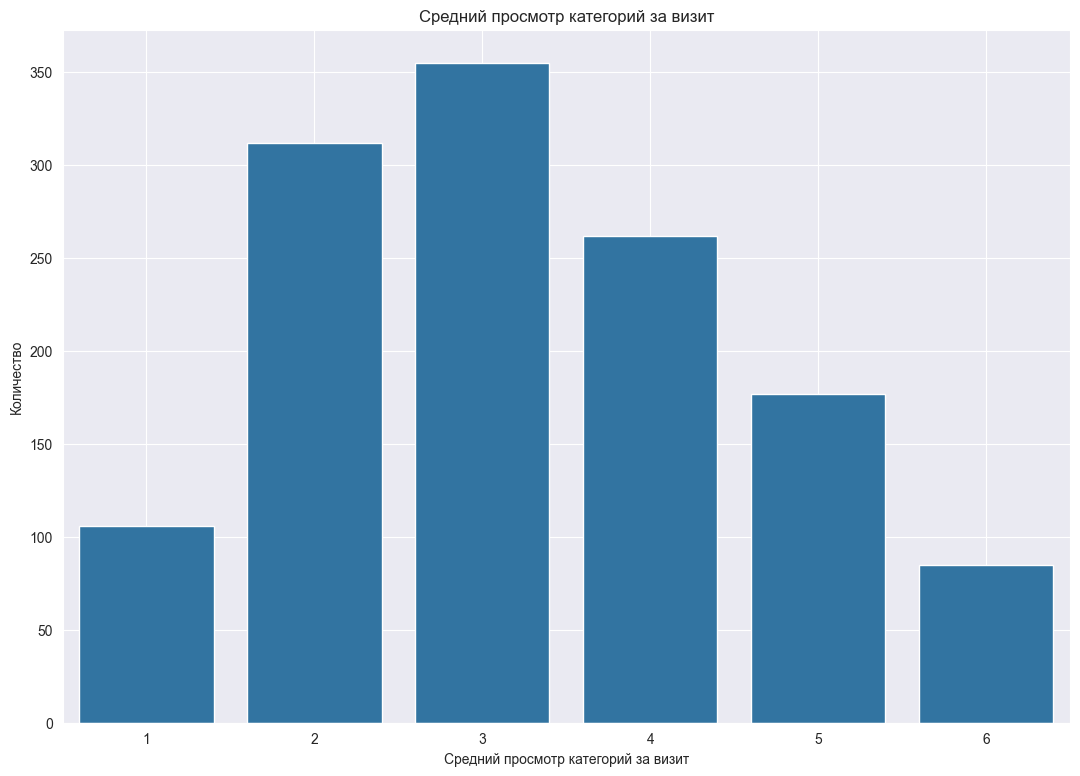

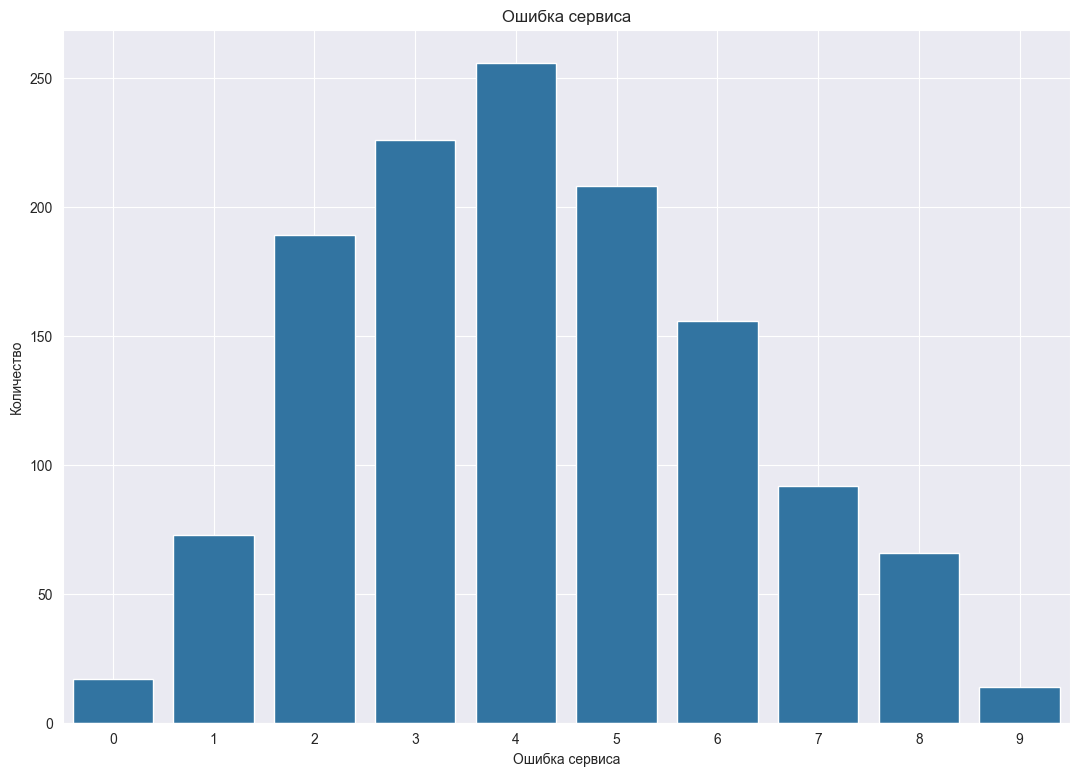

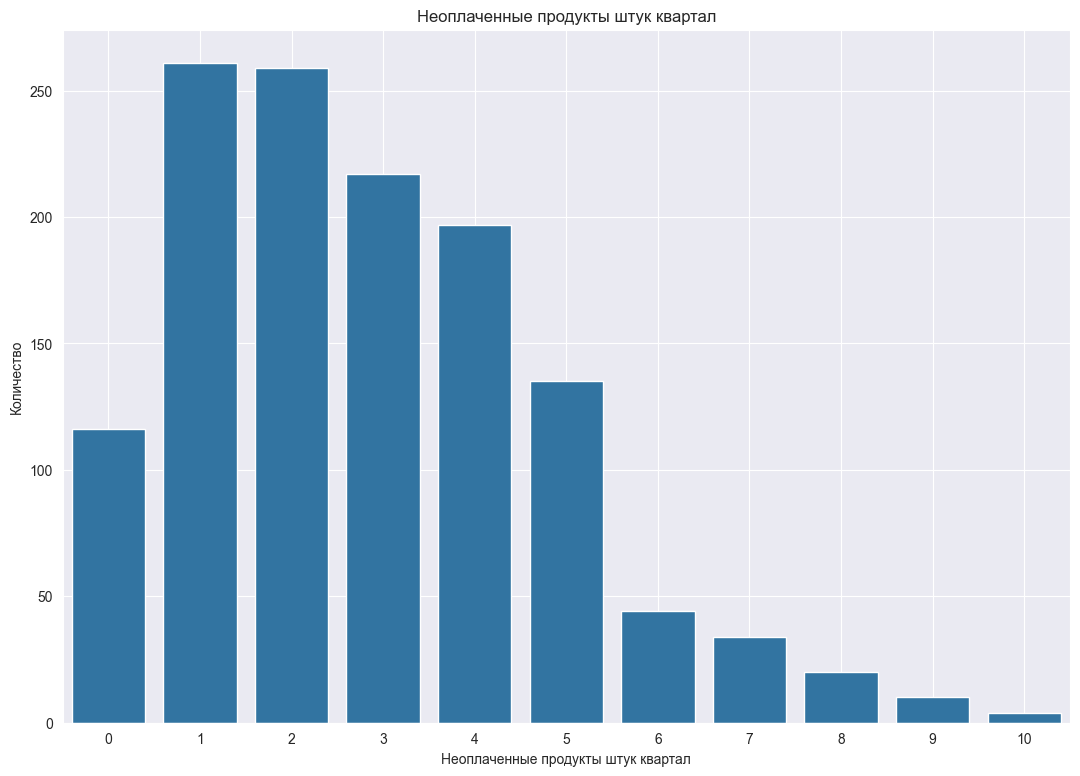

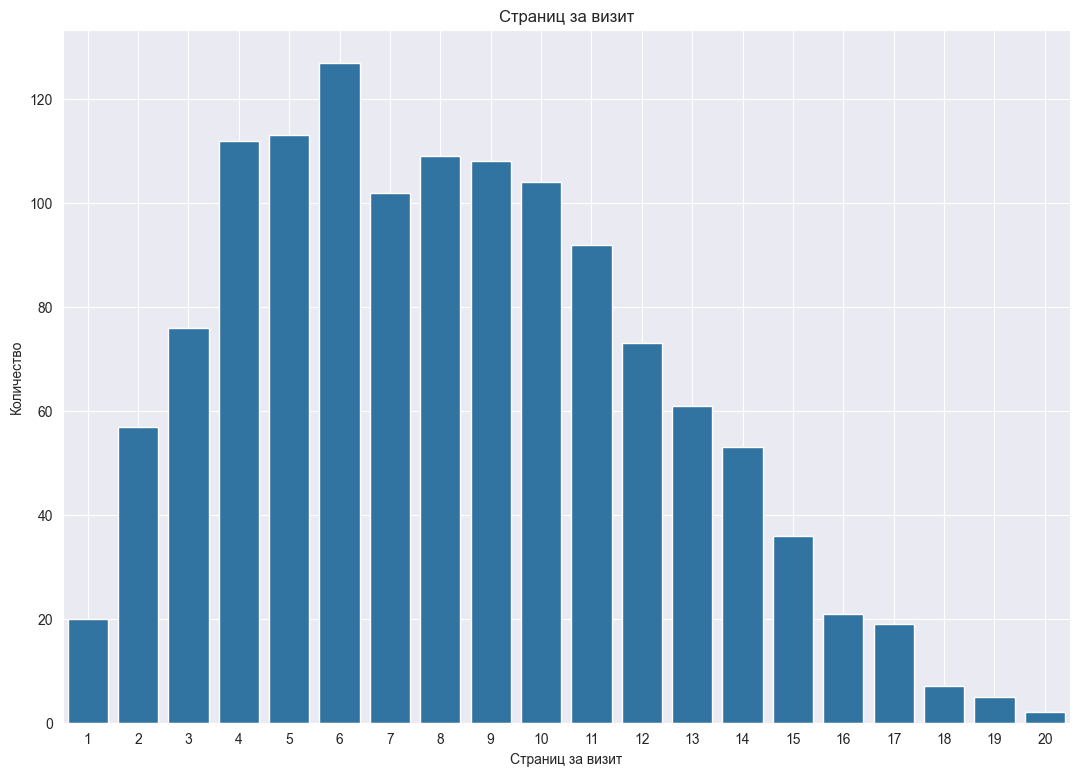

In [33]:
col = ['Маркет актив тек мес', 'Средний просмотр категорий за визит', 'Ошибка сервиса',
       'Неоплаченные продукты штук квартал', 'Страниц за визит']

for i in col:
    sns.countplot(x = market_file[i])
    plt.grid(True)
    plt.ylabel("Количество")
    plt.title(i)
    plt.show()
#sns.countplot(titanic, x="class", hue="survived", stat="percent")

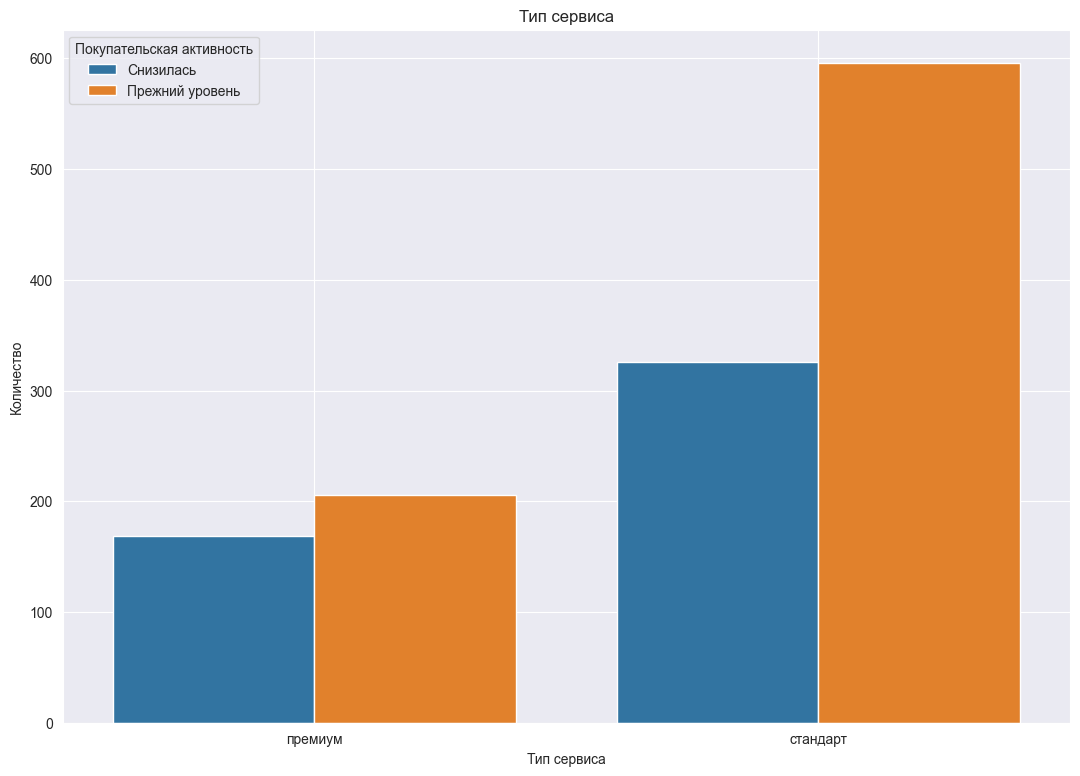

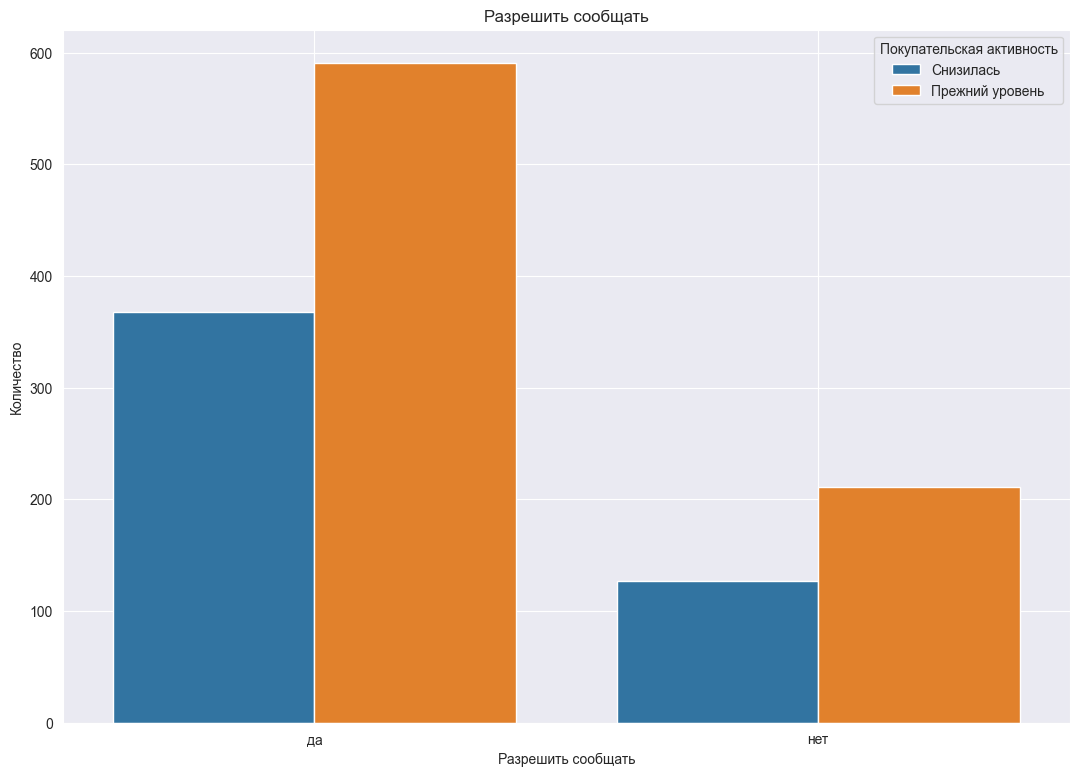

In [34]:
k = ['Тип сервиса', 'Разрешить сообщать']

for i in k:
    sns.countplot(data = market_file, x = i, hue='Покупательская активность')
    plt.grid(True)
    plt.ylabel("Количество")
    plt.title(i)
    plt.show()

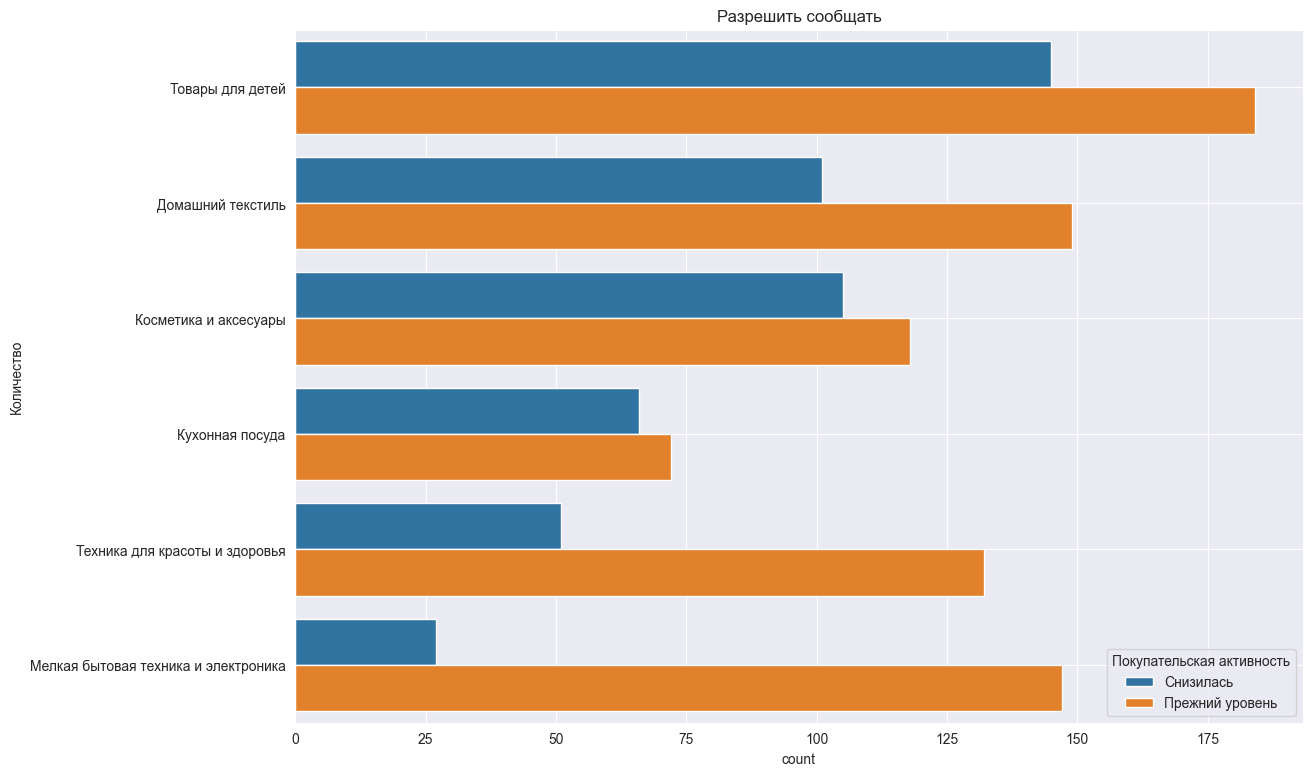

In [35]:
sns.countplot(data = market_file, y = 'Популярная категория', hue='Покупательская активность')
plt.grid(True)
plt.ylabel("Количество")
plt.title(i)
plt.show()

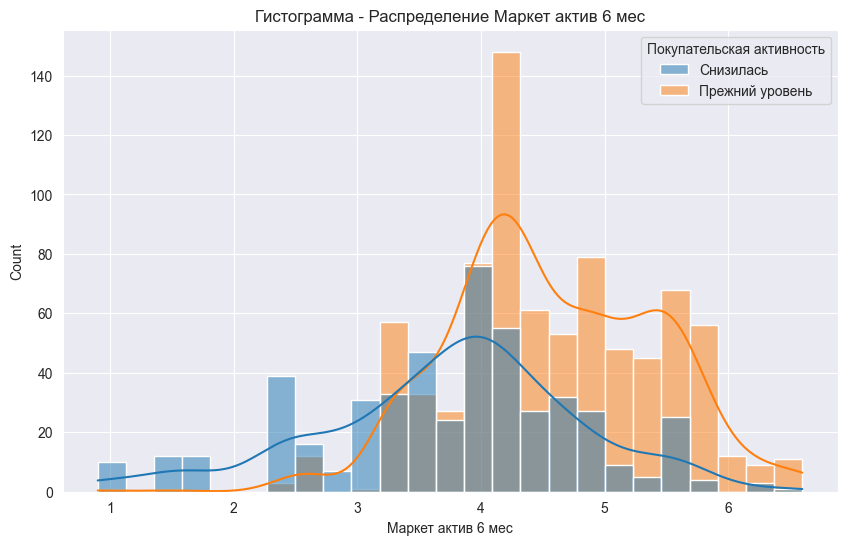

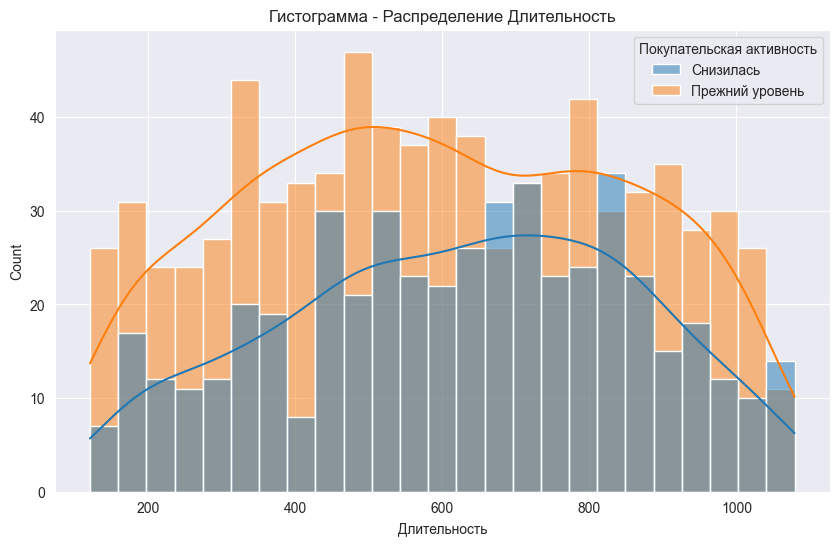

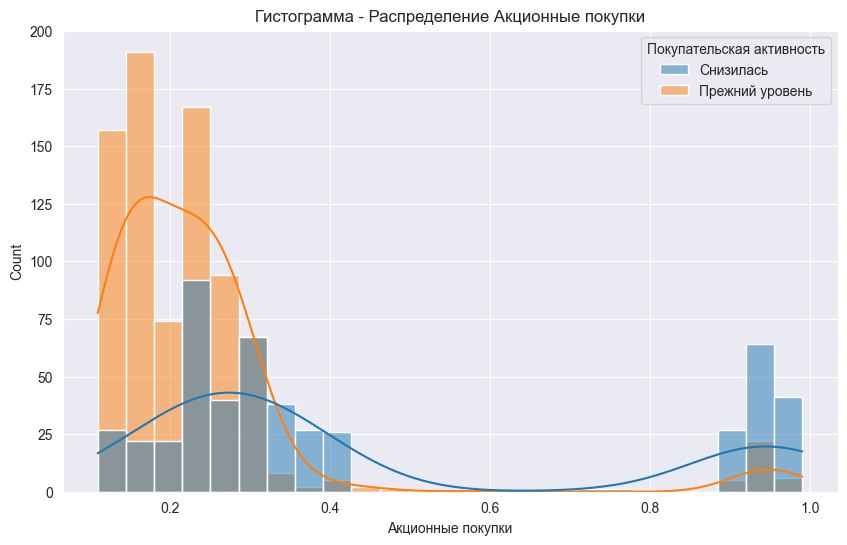

In [36]:
#неприрывные признаки
k = ['Маркет актив 6 мес', 'Длительность', 'Акционные покупки']
for i in k:
    plt.figure(figsize=(10, 6))
    sns.histplot(market_file, bins=25, kde=True, x=i, hue='Покупательская активность').set(title=(f'Гистограмма - Распределение {i}'))

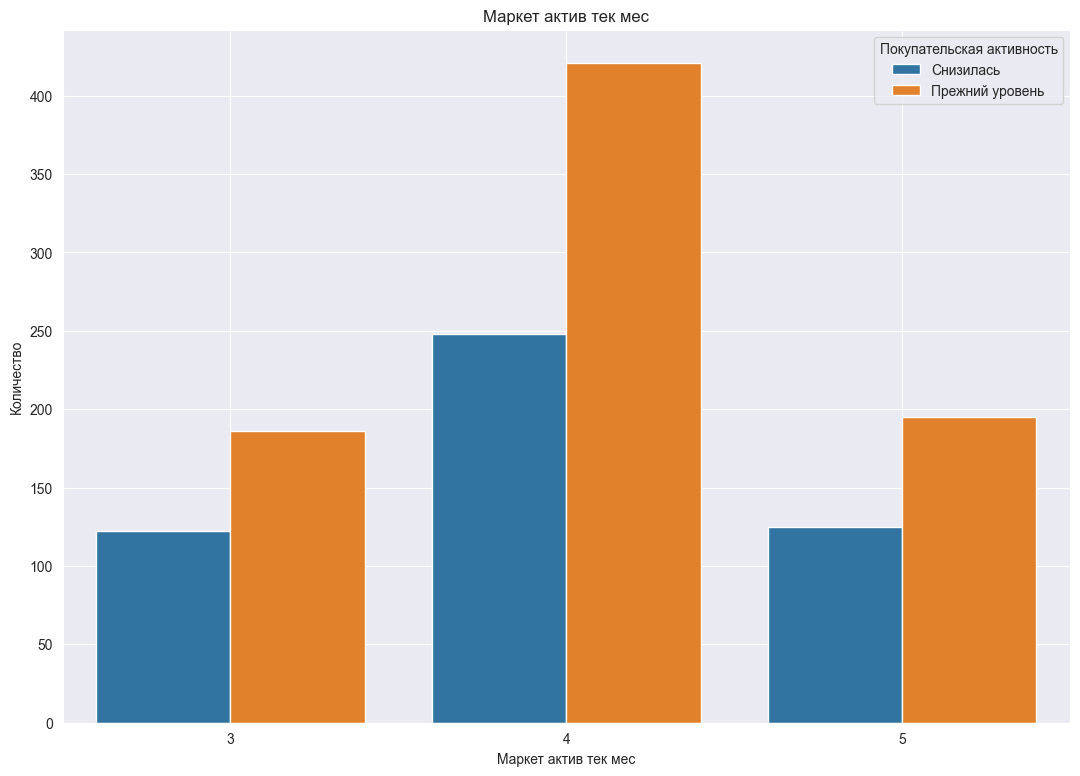

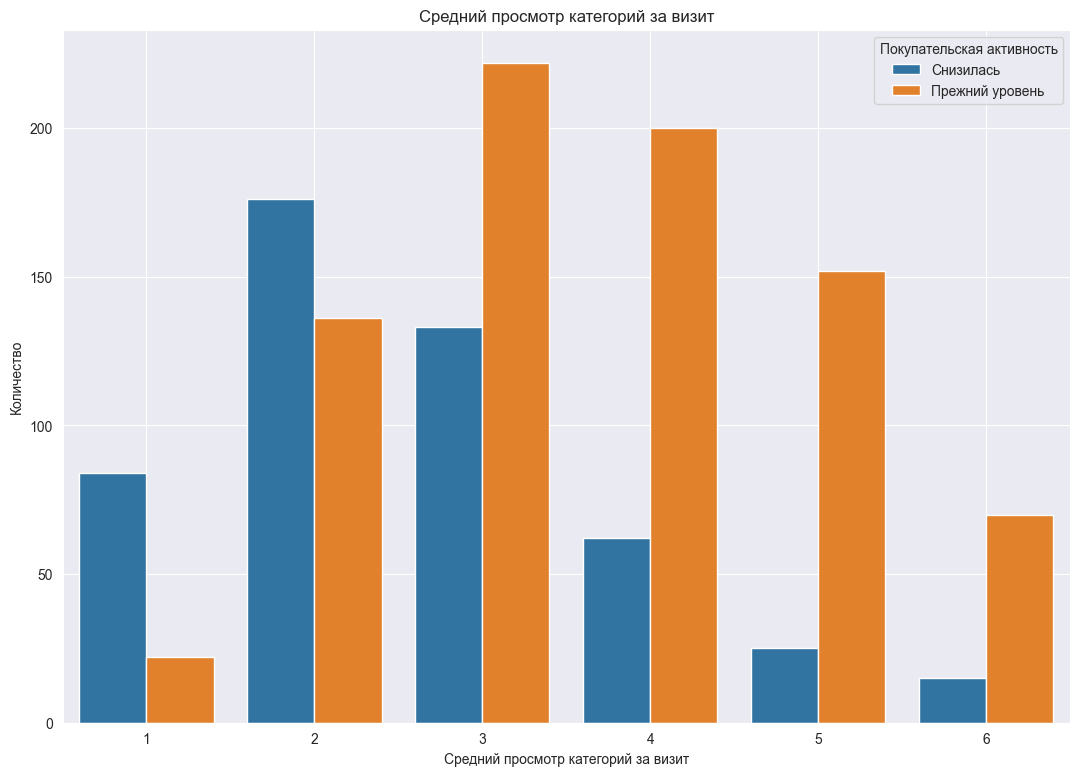

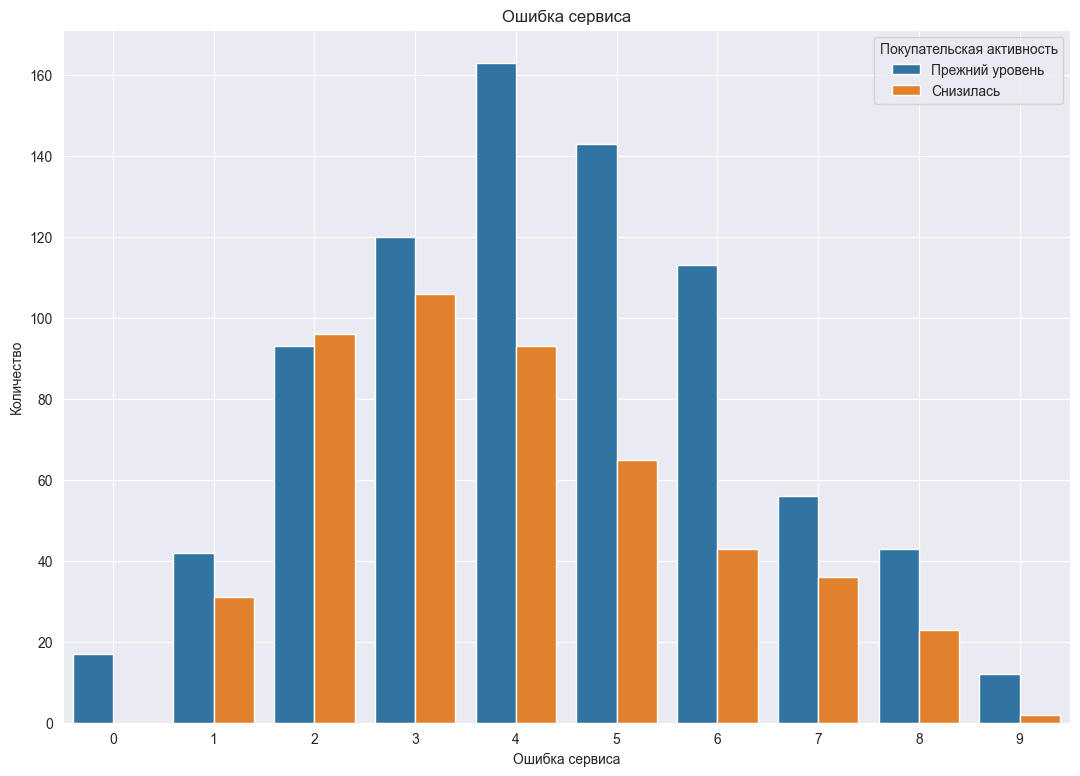

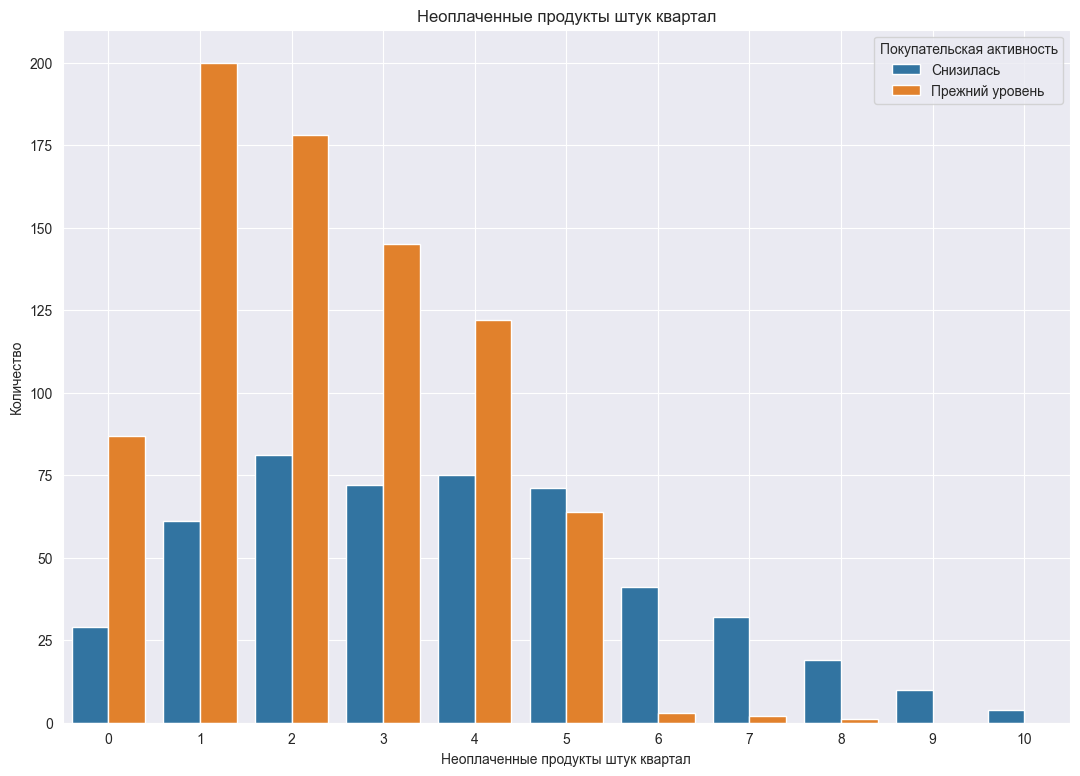

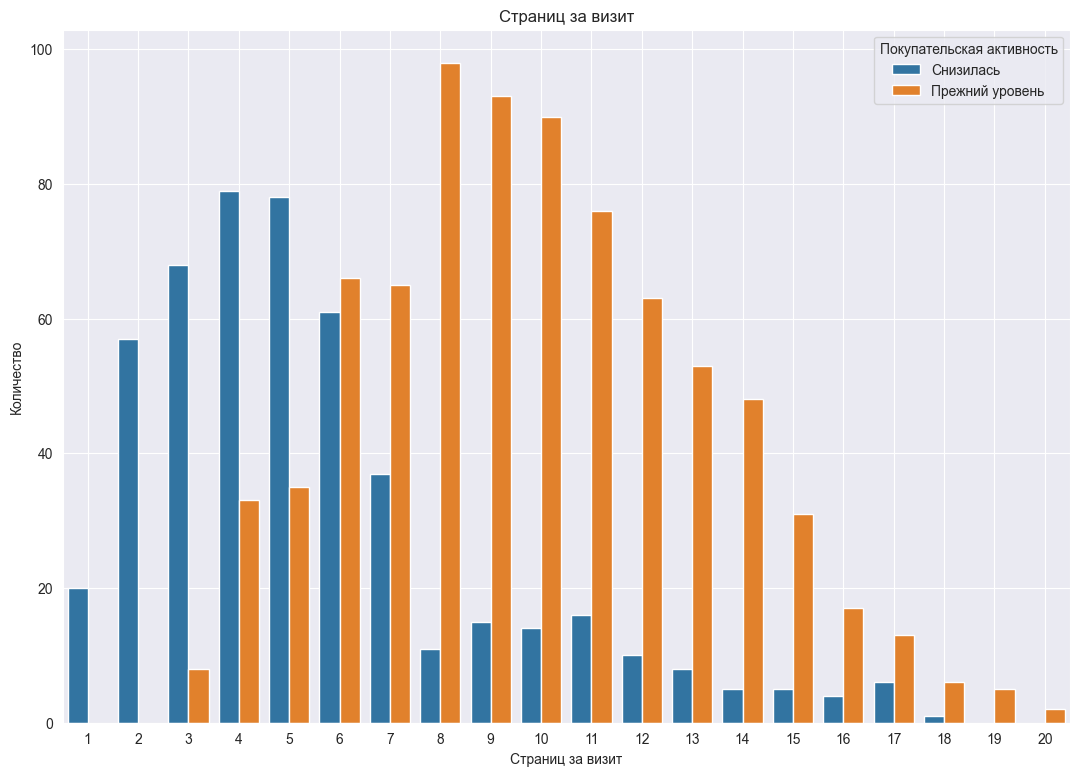

In [37]:
# дискретные признаки
col = ['Маркет актив тек мес', 'Средний просмотр категорий за визит', 'Ошибка сервиса',
       'Неоплаченные продукты штук квартал', 'Страниц за визит']


for i in col:
    sns.countplot(data = market_file, x = i, hue='Покупательская активность')
    plt.grid(True)
    plt.ylabel("Количество")
    plt.title(i)
    plt.show()

In [38]:
market_money.pivot_table(index='Период', values=['Выручка'], aggfunc='sum')

,Выручка
Период,
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0
текущий_месяц,6895434.7


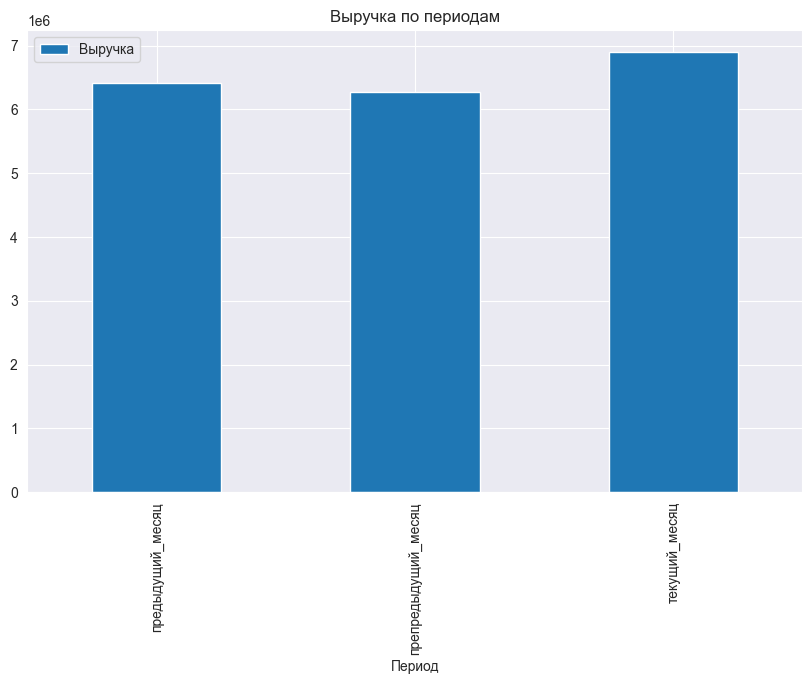

In [39]:
market_money.pivot_table(index='Период', values=['Выручка'], aggfunc='sum').plot(title='Выручка по периодам', figsize=(10, 6), kind='bar', grid=True);

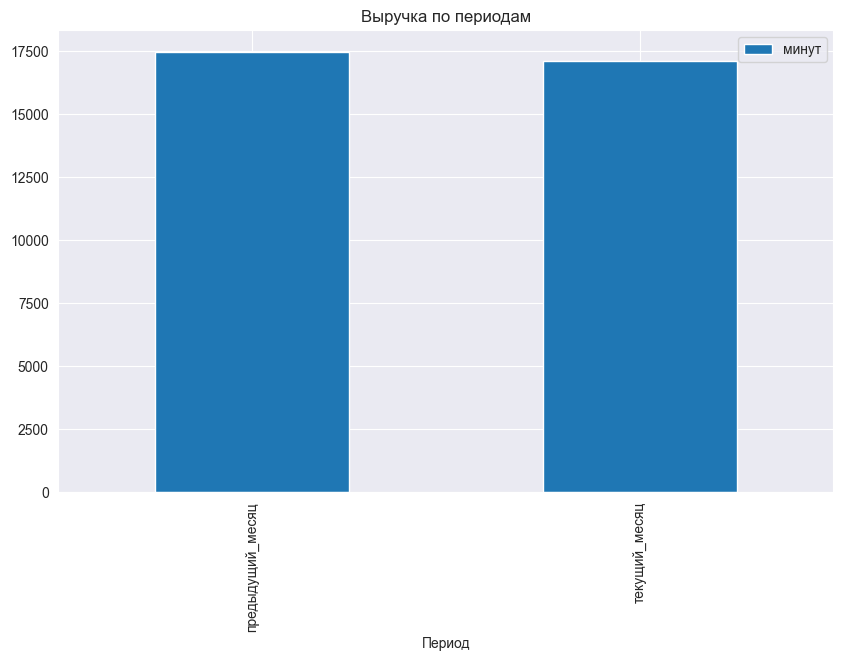

In [40]:
market_time.pivot_table(index='Период', values=['минут'], aggfunc='sum').plot(title='Выручка по периодам', figsize=(10, 6), kind='bar', grid=True);

#### Вывод
На данном этапе был проведен исследовательский анализ данных. 

 - Чаше всего просматривается 2-3 категории товаров. Чем меньше просмотренных категорий, тем вероятнее снижение покупательской активности.
 - около 3-10 страниц просматривается за раз. Чем меньше просмотренных страниц за визит, тем вероятнее снижение покупательской активности.
 - от того, как давно клиент зарегестрирован не говорит о его покупательской активности.
 - По данным акционных покупок заметили, что те, кто приобретают товары невзирая на скидки сохраняют сввою активность.
 - Исследовав данные по маркетинговой активности за 6 месяцев видим, что покупательская активность держится на прежнем уровне, у тех, у кого она выше. При значении меньше 4, покупательская активность снижается.

В датафрейме market_money:
 - Выручка держится примерно на одном уровне, однако за текущий месяц имеет наибольшее значение.

В датафрейме market_time:
 - Времени из месяца в месяц проводят одинаково.


## Шаг 4. Объединение таблиц
 Объединим таблицы market_file.csv, market_money.csv, market_time.csv. 



In [41]:
market_money_grouped = market_money.pivot_table(index=['id'], columns=["Период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
display(market_money_grouped.head())
market_money_grouped.info()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   выручка_предыдущий_месяц     1297 non-null   float64
 1   выручка_препредыдущий_месяц  1297 non-null   float64
 2   выручка_текущий_месяц        1297 non-null   float64
dtypes: float64(3)
memory usage: 40.5 KB


In [42]:
market_time_grouped = market_time.pivot_table(index=['id'], columns=["Период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
display(market_time_grouped.head())
market_time_grouped.info()

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215349,12.0,10.0
215350,8.0,13.0
215351,11.0,13.0
215352,8.0,11.0
215353,10.0,10.0


<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   минут_предыдущий_месяц  1297 non-null   float64
 1   минут_текущий_месяц     1297 non-null   float64
dtypes: float64(2)
memory usage: 30.4 KB


In [43]:
data = pd.merge(pd.merge(market_file, market_money_grouped, on='id'), market_time_grouped, on='id')
display(data.head())
data.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет актив 6 мес                   1297 non-null   float64
 5   Маркет актив тек мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные покупки                    1297 non-null   float64
 8   Популярная категория                 1297 non-null   object 
 9   Средний просмотр категорий за визит  1297 non-null   int64  
 10  Неоплаченные продукты штук квартал   1297 non-null   int64  
 11  Ошибка сервиса                

#### Вывод
Теперь после объеденения датасетов все характеристики в одной таблице.
Созданный датафрейм data объединяющий таблицы market_file, market_money_grouped, market_time_grouped в своем составе имеет 1297 строк и 18 столбцов. Было использовано соединение по умолчанию (внутреннее), в итоговом датафрейме количество строк соотвествует количеству строк в market_money => соединение произведено корректро, пропуски отсутствуют


## Шаг 5. Корреляционный анализ
Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

data[data.columns[data.columns != 'id']].corr(method='spearman')

#непрерывные признаки:
k =  ['Маркет актив 6 мес', 'Длительность',
      'Акционные покупки', 'Средний просмотр категорий за визит',
      'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
      'минут_предыдущий_месяц', 'минут_текущий_месяц']

corr_matrix = data[data.columns[data.columns != 'id']].phik_matrix(interval_cols = k)
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Матрица корреляции')
plt.show()

#### Вывод:

Проанализировав матрицу корреляции можно сделать вывод, что целевой признак - Покупательская активность - коррелирует с количеством страниц за визит, сколько времени проводили в предыдущий месяц и текущий, а так же со Средним просмотром категорий за визит, Неоплаченными продуктами в корзине за квартал, Акционными покупками

мультиколлинеарность слабовыражена.

## Шаг 6. Использование пайплайнов

Поскольку наблюдается дисбаланс целевоко признака необходимо использовать - ROC-AUC, метрика не чувствительна к дисбалансу классов.

In [44]:

TEST_SIZE = 0.25
RANDOM_STATE = 42


# X = market_full.drop(['Покупательская_активность'], axis=1)
X = data.drop(['id', 'Покупательская активность'], axis=1)
y = data['Покупательская активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)


# создадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучим модель и трансформируйте тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)
# конвертировать объект NumPy array в Pandas DataFrame
#y_train = pd.DataFrame(y_train)
#y_test = pd.DataFrame(y_test)

ohe_columns = ['Популярная категория']
#ohe_columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная категория']
#ord_columns = ['Акционные покупки']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']
num_columns = ['Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность', 'Акционные покупки', 
               'Средний просмотр категорий за визит',
               'Неоплаченные продукты штук квартал', 'Ошибка сервиса',
               'Страниц за визит', 'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
               'минут_предыдущий_месяц', 'минут_текущий_месяц']
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    #('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
)
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['стандарт', 'премиум'],
                                      ['нет', 'да']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        
        (
            'simple_imputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

# прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
probas = randomized_search.predict_proba(X_test) [:,1]

In [45]:
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probas)}')
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 



Метрика лучшей модели на тренировочной выборке: 0.9
Метрика ROC-AUC на тестовой выборке: 0.9233269138180067
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_before_ord',
    

С использованием пайпланов из библиотеки sklearn были обучены модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). При обучении моделей средстави пайплана преебирались некоторое количество гиперпараметров моделей с целью нахождения модели, которая даст лучший результат. По результатам обучения лучшей стала модель LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear'). Метрика roc_auc для тренеровочной выборки 0.90 для тестовой 0.92. 

## Шаг 7. Анализ важности признаков

7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
7.2 Сделайте выводы о значимости признаков:

 • какие признаки мало значимы для модели;
 • какие признаки сильнее всего влияют на целевой признак;
 • как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.


# Извлечение лучшей модели
best_pipeline = randomized_search.best_estimator_
best_model = best_pipeline.named_steps['models']
preprocessor = best_pipeline.named_steps['preprocessor']

# Преобразование тестовых данных
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# Вычисление SHAP значений для тестовой выборки
explainer = shap.Explainer(best_model, masker=preprocessor.transform(X_train))
shap_values = explainer(preprocessor.transform(X_test))


# Визуализация - Не работает! :(
#shap_values.feature_names = preprocessor.get_feature_names_out()
#shap.plots.bar(shap_values)

shap.summary_plot(
    shap_values,
    preprocessor.transform(X_test),
    feature_names=preprocessor.get_feature_names_out(),
    plot_type='bar'
)

#### Вывод:
Страниц_за_визит, Средний_просмотр_категорий_за_визит, мин_предыдущий_месяц, Неоплаченные продукты штук квартал, Акционные покупки - наиболее значимые факторы, которые влияют на значение целевого признака. Вывод выглядит логичным, так как чем больше покупатель просмативает страниц, категорий, доавляет товаров в корзину тем больше вероятность совершения покупки.

Малозначимые признаки для модели - Выручка_текущий_месяц, Популярные категории, Маркет_актив_тек_мес, Разрешить сообщать, Ошибка_сервиса, Тип_сервиса.

## Шаг 8. Сегментация покупателей

8. Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.


Для последующей сегментации добавим колонку - Вероятность снижения

In [46]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

In [47]:
y_pred = randomized_search.predict(X_combined)
predictions_df = pd.DataFrame(y_pred, columns=["прогноз"])

In [48]:
y_proba = randomized_search.predict_proba(X_combined)[:, 1]
prob_class1_df = pd.DataFrame(y_proba, columns=["вероятность_снижения"])

In [49]:
data['прогноз'] = predictions_df
data['вероятность_снижения'] = prob_class1_df
data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,0,0.079619
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,1,0.577212
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,0,0.054577
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,0,0.330836
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,1,0.910521


Обьединим итогувую таблицу с таблицу с прибылью.

In [50]:
data = data.merge(money, on='id', how='inner')

In [51]:
data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,...,Ошибка сервиса,Страниц за визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12.0,10.0,0,0.079619,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,5457.5,4826.0,5058.4,8.0,13.0,1,0.577212,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11.0,13.0,0,0.054577,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8.0,11.0,0,0.330836,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,4738.5,5124.0,5388.5,10.0,10.0,1,0.910521,3.95


count    1297.000000
mean        0.385098
std         0.358220
min         0.002669
25%         0.077060
50%         0.215713
75%         0.773505
max         0.999021
Name: вероятность_снижения, dtype: float64

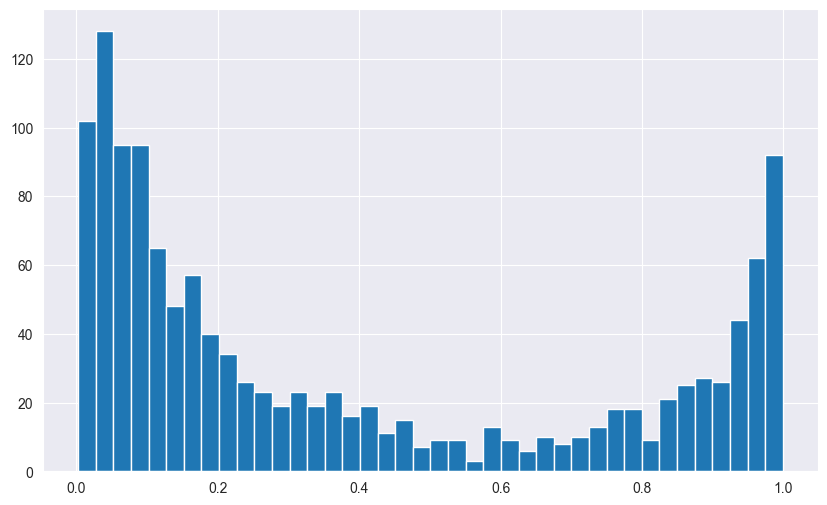

In [52]:
data['вероятность_снижения'].hist(bins=40, figsize=(10, 6))
data['вероятность_снижения'].describe()

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

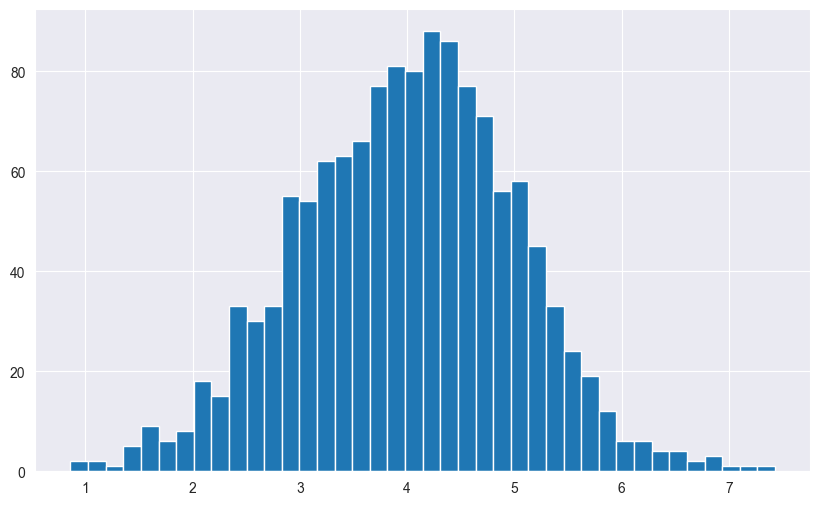

In [53]:
data['Прибыль'].hist(bins=40, figsize=(10, 6))
data['Прибыль'].describe()

Отберем группу покупателей с высокой вероятностью снижения покупательской активности и высокой прибылью.

In [54]:
data['сегментация'] = data.apply(lambda x: 'Исследуемый сегмент' if x['вероятность_снижения'] > 0.5 and x['Прибыль'] > 4 else 'Остальные пользователи', axis=1)

In [55]:
data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,...,Страниц за визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения,Прибыль,сегментация
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,5,5216.0,4472.0,4971.6,12.0,10.0,0,0.079619,4.16,Остальные пользователи
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,5,5457.5,4826.0,5058.4,8.0,13.0,1,0.577212,3.13,Остальные пользователи
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,4,6158.0,4793.0,6610.4,11.0,13.0,0,0.054577,4.87,Остальные пользователи
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,2,5807.5,4594.0,5872.5,8.0,11.0,0,0.330836,4.21,Остальные пользователи
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,4,4738.5,5124.0,5388.5,10.0,10.0,1,0.910521,3.95,Остальные пользователи


In [56]:
data[data['сегментация'] == 'Остальные пользователи'].describe()

,id,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения,Прибыль
count,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000
mean,215997.100276,4.257038,4.012879,604.538178,0.325005,3.295308,2.833487,4.137075,8.269549,4938.647654,4834.426863,5318.992916,13.430543,13.185833,0.204232,0.293544,3.848684
std,374.275315,1.022259,0.699789,250.925319,0.253793,1.352375,1.977046,1.944576,3.960907,704.276194,334.422732,3194.747427,3.951421,4.226382,0.403325,0.312292,1.005965
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000,0.000000,0.002669,0.860000
25%,215675.500000,3.750000,4.000000,402.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4491.000000,4581.000000,4675.350000,10.000000,10.000000,0.000000,0.063828,3.160000
50%,216000.000000,4.200000,4.000000,606.000000,0.240000,3.000000,3.000000,4.000000,8.000000,5004.500000,4813.000000,5173.700000,13.000000,13.000000,0.000000,0.157377,3.820000
75%,216318.500000,4.900000,5.000000,812.500000,0.300000,4.000000,4.000000,5.000000,11.000000,5394.750000,5057.000000,5718.200000,17.000000,16.000000,0.000000,0.404574,4.530000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,106862.200000,23.000000,23.000000,1.000000,0.997880,7.020000


In [57]:
data[data['сегментация'] == 'Исследуемый сегмент'].describe()

,id,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения,Прибыль
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.0,210.000000,210.000000
mean,216008.752381,4.240952,3.990476,595.000000,0.297476,3.123810,2.880952,4.428571,7.757143,4998.507143,4846.414286,5303.282857,13.671429,13.342857,1.0,0.859000,4.768476
std,376.889975,0.982789,0.677672,239.860406,0.226210,1.360377,1.958937,1.970389,4.042013,684.689228,328.903623,808.813917,3.860193,4.195757,0.0,0.140359,0.604164
min,215355.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2909.000000,4119.000000,3328.900000,5.000000,6.000000,1.0,0.506292,4.010000
25%,215671.250000,3.700000,4.000000,434.500000,0.170000,2.000000,1.000000,3.000000,4.000000,4600.250000,4612.500000,4782.225000,11.000000,10.000000,1.0,0.772370,4.310000
50%,215982.500000,4.150000,4.000000,617.500000,0.240000,3.000000,3.000000,4.000000,7.000000,5017.500000,4810.500000,5240.600000,14.000000,13.000000,1.0,0.915632,4.640000
75%,216348.750000,4.900000,4.000000,778.750000,0.297500,4.000000,4.000000,6.000000,10.000000,5468.000000,5040.500000,5880.350000,17.000000,16.000000,1.0,0.971418,5.097500
max,216646.000000,6.600000,5.000000,1073.000000,0.990000,6.000000,10.000000,9.000000,19.000000,6531.000000,5637.000000,7114.200000,23.000000,22.000000,1.0,0.999021,7.430000


Всего 210 клиентов с высокой вероятностью снижения покупательской активности и высокой выручки (или 16%).

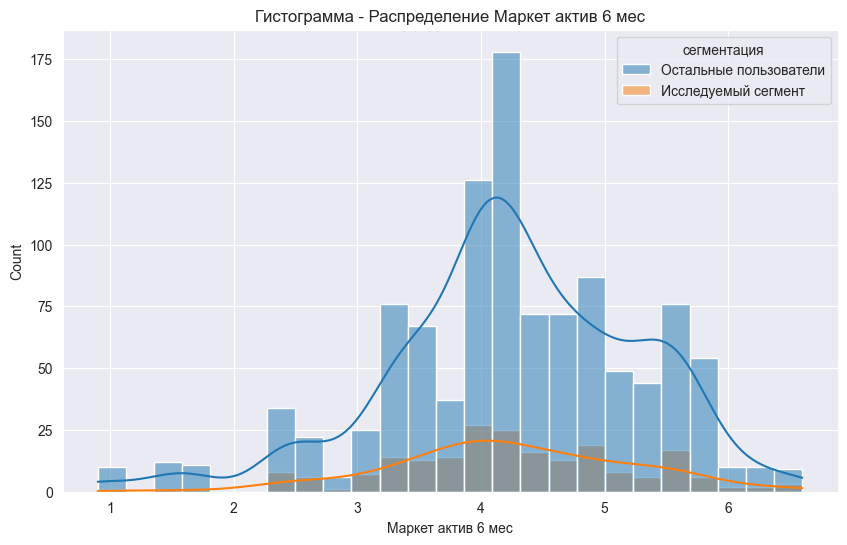

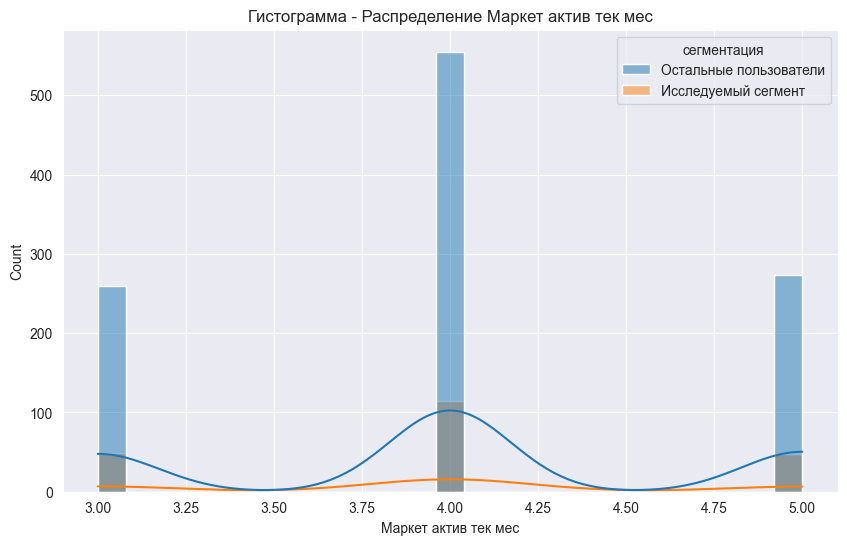

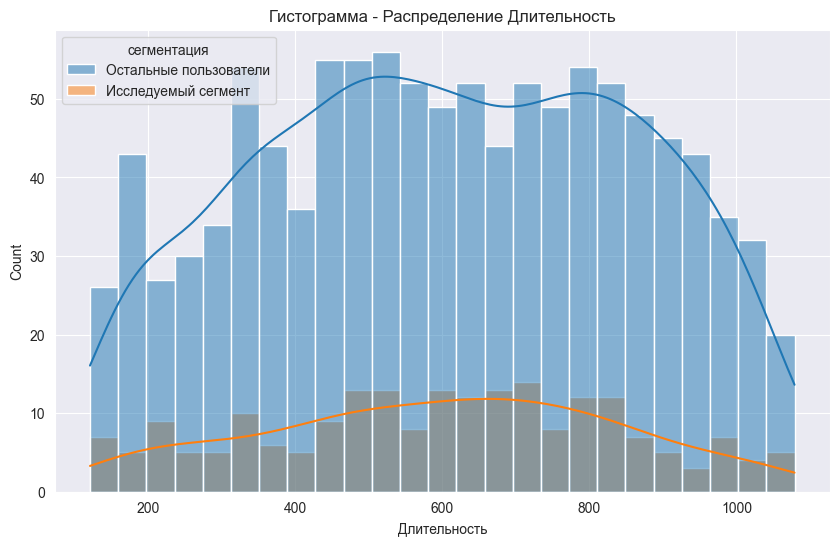

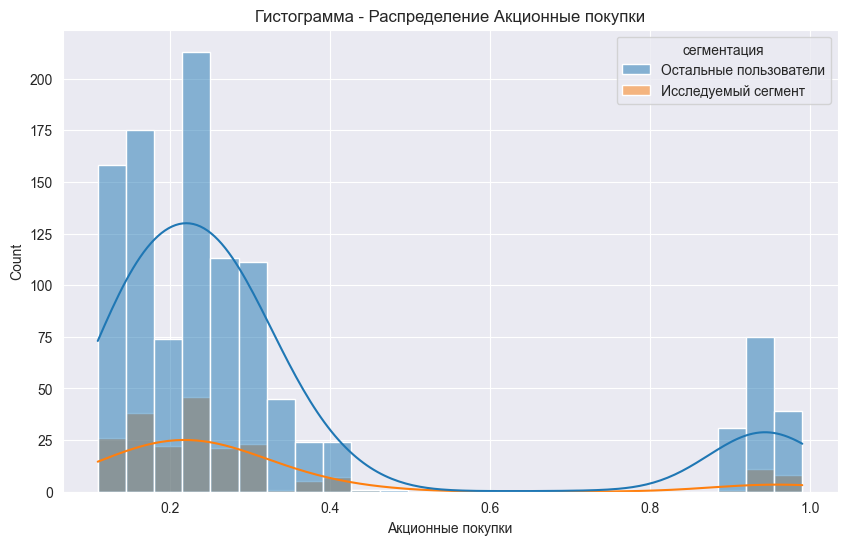

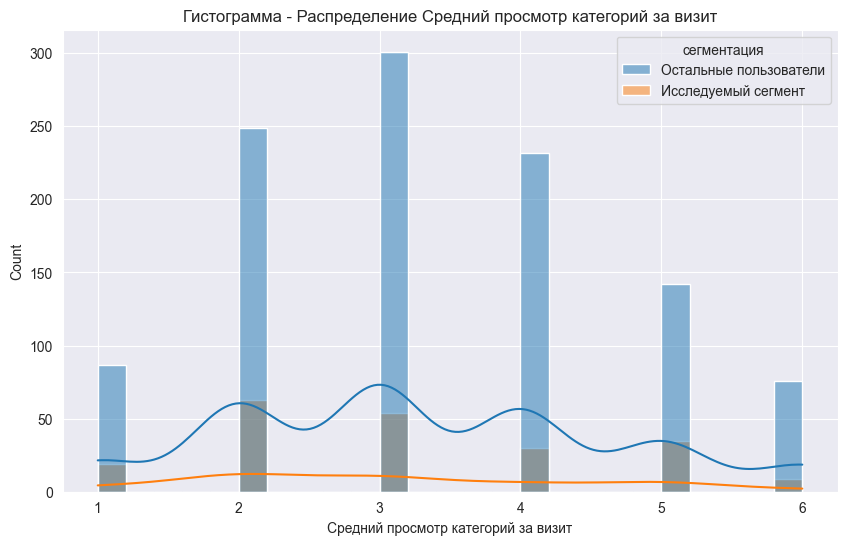

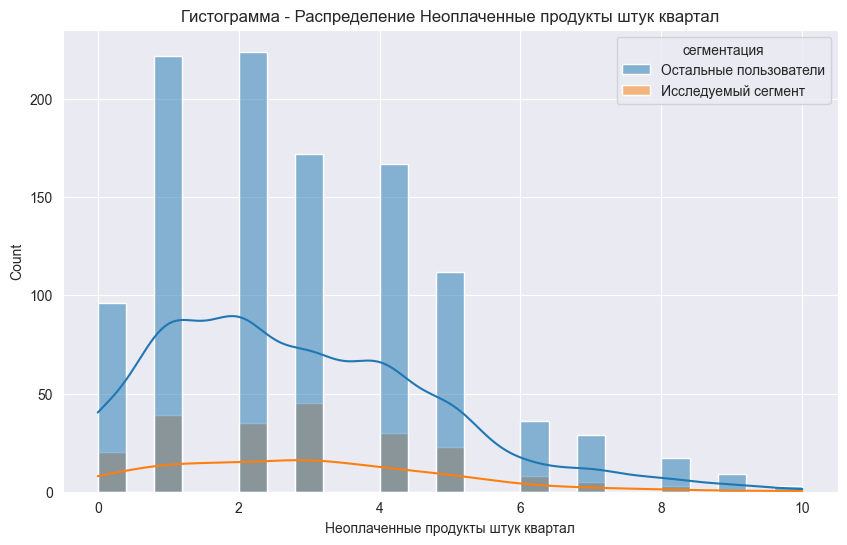

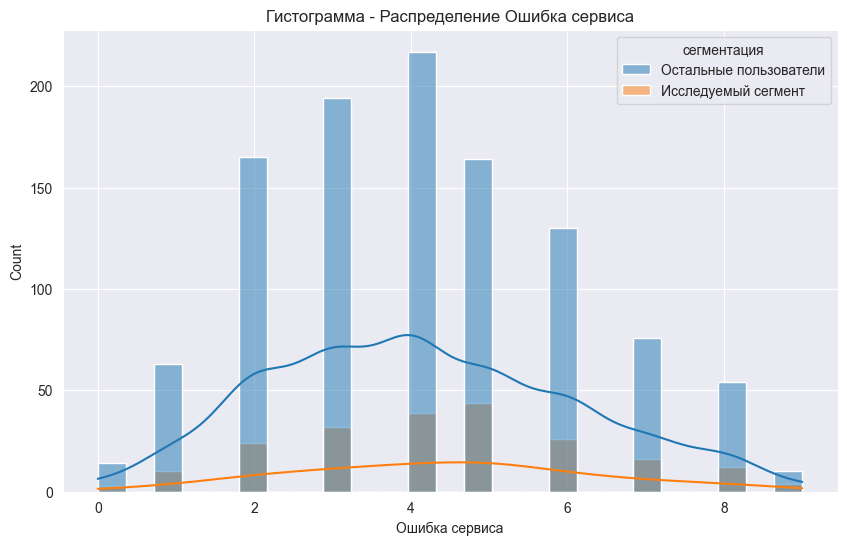

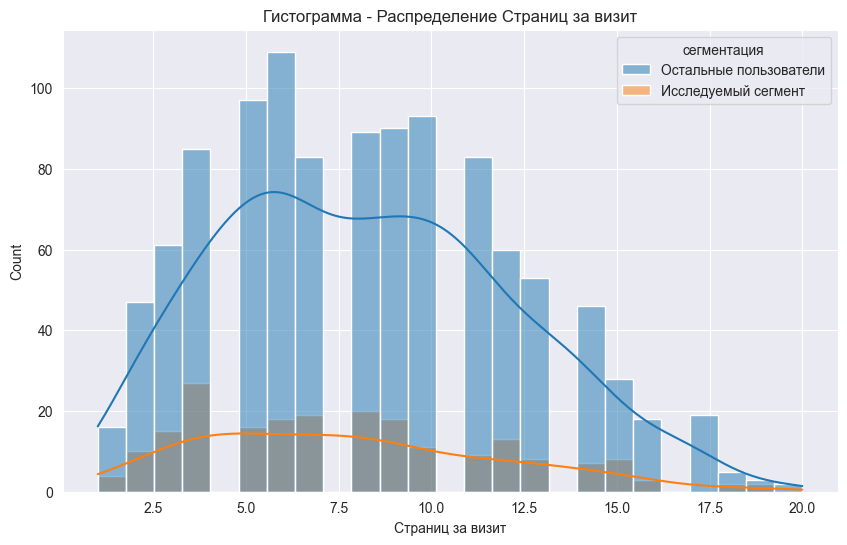

In [58]:
k = ['Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность',
       'Акционные покупки',
       'Средний просмотр категорий за визит',
       'Неоплаченные продукты штук квартал', 'Ошибка сервиса',
       'Страниц за визит']

for i in k:
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=25, kde=True, x=i, hue='сегментация').set(title=(f'Гистограмма - Распределение {i}'))

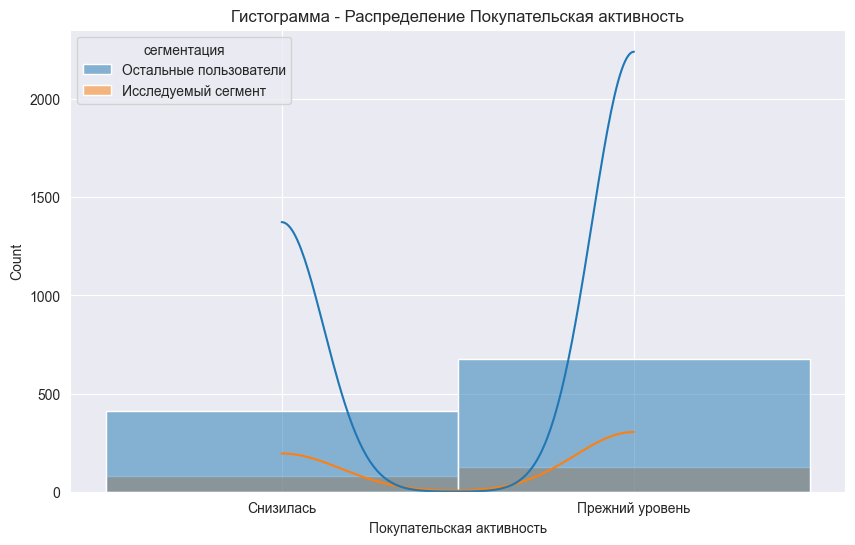

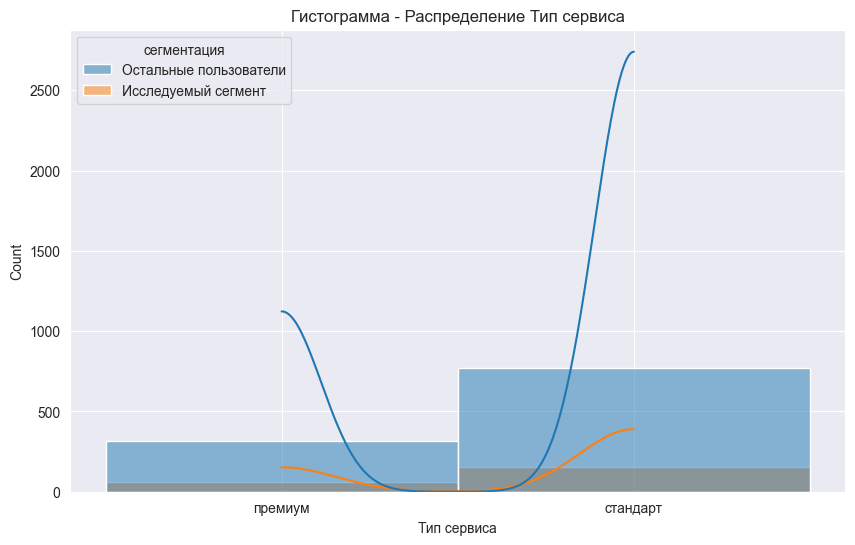

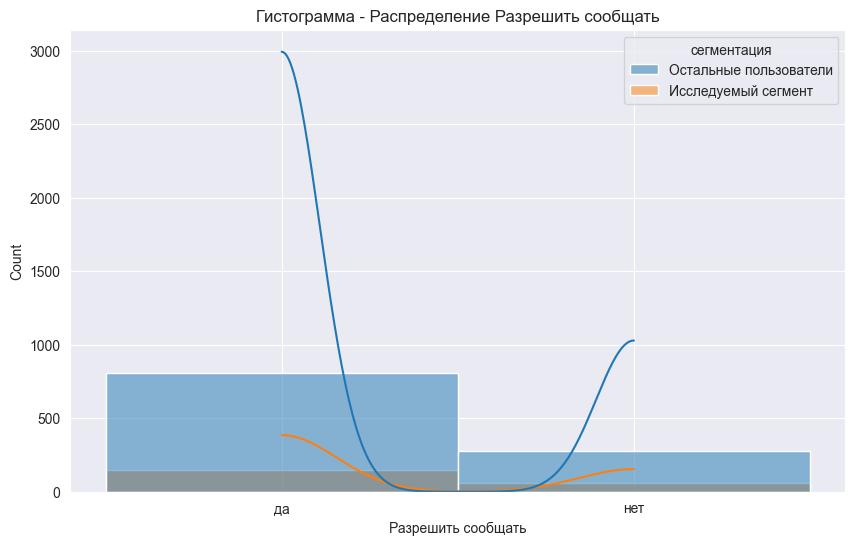

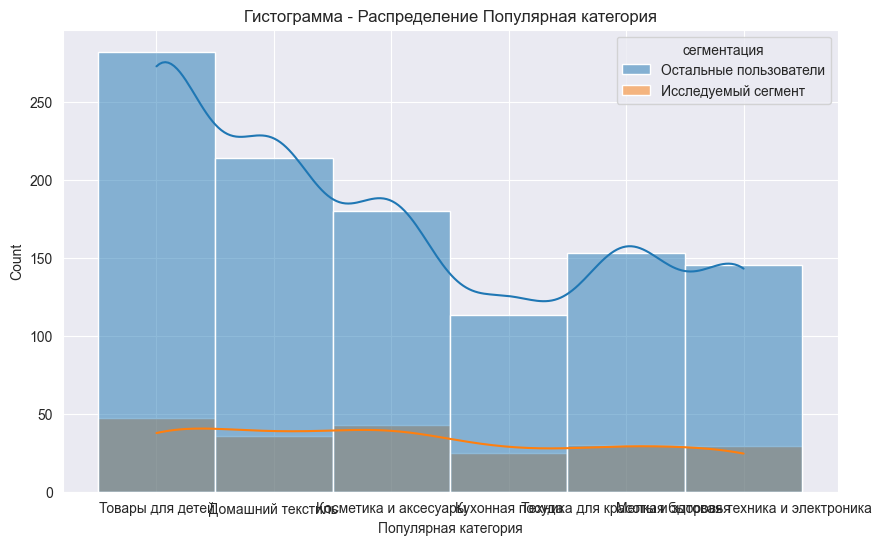

In [59]:
n = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная категория']

for i in n:
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=25, kde=True, x=i, hue='сегментация').set(title=(f'Гистограмма - Распределение {i}'))

#### Вывод:

Была отобрана категория в высокой вероятностью снижения покупательской активностью и с наибольшей прибылью:
 - Поведение данного сегмента мало отличается от поведения всей выборки, однако можно выделить следущее
 - исследуемый сегмент реже совершает покупки по акции, вероятно такие покупатели заходят на маркетплей с определенной конкретной целью купить что-то не смотря на акцию, либо дело в рекомендательной системе, 
 - Косметика и акссесуары, а также товары для детей наиболее предпочитетльные категории для исследуемой группы.
 - отличается распределение по количеству просмативаемых страниц: исследуемый сегмент просматривает меньшее количество страниц
 - рассылка с предложением товаров мало влияет на покупательскую активность - возможно имеет смысл направить ресурсы/бюджет на другие способы увеличения активности
 - уровень сервиса - очевидно у исследуемой категории клиентов чаще "стандарт". 


Рекомендации:

Вероятно необходимо направить ресурсы на поведение покупателя на сайте, так как данные ключевые факторы в большей степени влияют на вероятность изменения покупательской активности. Следовательно необходимо: стимулировать вовлеченность клиента, увеличить количество просматриваемых страниц и категорий покупателем, его длительность нахождения на сайте (т.к. это увеличит вероятность нахождения то что требуется). Этому может поспособствовать внедрение/улучнение рекомендательных систем, изменение дизайна интерфейса, таргетированная реклама.

## Шаг 9. Общий вывод

#### Загрузка данных
В нашем распоряжении 4 таблицы
В таблице market_file 1300 записи и 13 столбцов.
В таблице market_money 3900 записей и 3 столбца. 
В таблице market_time 2600 записей и 3 столбца.
В таблице money 1300 записей и 2 столбца.


#### Предобработка данных
Во всех датафреймах не было пропусков и дубликатов.
- В датафрейме market_file были приведены к корректному виду названия столбцов, заменены данные в столбце 'Тип сервиса' на корректные.
- В датафрейме market_money были заменены типы данных.
- В датафрейме market_time были заменены значения в столбце 'Период' на корректное.
- В датафрейме money были заменены типы данных.


#### Исследовательский анализ данных
отобраны клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
- покупательская_активность снизилась у 38,2% клиентов. больше 1/3 покупателей - достаточно высокий показатель. 
- премиум сервисом пользуются 28,9% от всей выборки клиентов.
- 74% клиентов дают согласие на рассылки по товару.

 - Чаше всего просматривается 2-3 категории товаров. Чем меньше просмотренных категорий, тем вероятнее снижение покупательской активности.
 - около 3-10 страниц просматривается за раз. Чем меньше просмотренных страниц за визит, тем вероятнее снижение покупательской активности.
 - от того, как давно клиент зарегестрирован не говорит о его покупательской активности.
 - По данным акционных покупок заметили, что те, кто приобретают товары невзирая на скидки сохраняют сввою активность.
 - Исследовав данные по маркетинговой активности за 6 месяцев видим, что покупательская активность держится на прежнем уровне, у тех, у кого она выше. При значении меньше 4, покупательская активность снижается.

В датафрейме market_money:
 - Выручка держится примерно на одном уровне, однако за текущий месяц имеет наибольшее значение.

В датафрейме market_time:
 - Времени из месяца в месяц проводят одинаково.



#### Объеденение таблиц
Датасеты market_file, market_money, market_time были объеденены в один датафрейм.


#### Корреляционный анализ
Проанализировав матрицу корреляции можно сделать вывод что целевой признак Покупательская активность коррелирует с количеством страниц за визит, сколько времени проводили в предыдущий месяц и текущий, а так же со Средним просмотром категорий за визит, Неоплаченными продуктами в корзине за квартал, Акционными покупками

Мультиколлинеарность слабовыражена.

#### Обучение модели
С использованием пайпланов из библиотеки sklearn были обучены модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). При обучении моделей средстави пайплана преебирались некоторое количество гиперпараметров моделей с целью нахождения модели, которая даст лучший результат.
По результатам обучения лучшей стала модель LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear'). Метрика roc_auc для тренеровочной выборки 0.90 для тестовой 0.92.

#### Анализ важности признаков
Страниц_за_визит, Средний_просмотр_категорий_за_визит, мин_предыдущий_месяц, Неоплаченные продукты штук квартал, Акционные покупки - наиболее значимые факторы, которые влияют на значение целевого признака. Вывод выглядит логичным, так как чем больше покупатель просмативает страниц, категорий, доавляет товаров в корзину тем больше вероятность совершения покупки.

Малозначимые признаки для модели - Выручка_текущий_месяц, Популярные категории, Маркет_актив_тек_мес, Разрешить сообщать, Ошибка_сервиса, Тип_сервиса.

#### Сегментация
Была отобрана категория в высокой вероятностью снижения покупательской активностью и с наибольшей прибылью:
 - Поведение данного сегмента мало отличается от поведения всей выборки, однако можно выделить следущее
 - исследуемый сегмент реже совершает покупки по акции, вероятно такие покупатели заходят на маркетплей с определенной конкретной целью купить что-то не смотря на акцию, либо дело в рекомендательной системе, 
 - Косметика и акссесуары, а также товары для детей наиболее предпочитетльные категории для исследуемой группы.
 - отличается распределение по количеству просмативаемых страниц: исследуемый сегмент просматривает меньшее количество страниц
 - рассылка с предложением товаров мало влияет на покупательскую активность - возможно имеет смысл направить ресурсы/бюджет на другие способы увеличения активности
 - уровень сервиса - очевидно у исследуемой категории клиентов чаще "стандарт". 

Рекомендации:

Вероятно необходимо направить ресурсы на поведение покупателя на сайте, так как данные ключевые факторы в большей степени влияют на вероятность изменения покупательской активности. Следовательно необходимо: стимулировать вовлеченность клиента, увеличить количество просматриваемых страниц и категорий покупателем, его длительность нахождения на сайте (т.к. это увеличит вероятность нахождения то что требуется). Этому может поспособствовать внедрение/улучнение рекомендательных систем, изменение дизайна интерфейса, таргетированная реклама.